https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

c:\Users\luisc\miniconda3\envs\recurrent_neural_network\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel('epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [3]:
dataset, info = tfds.load(
    'imdb_reviews',
    with_info=True,
    as_supervised=True
)

train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to ~\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
    print(f'Text: {example.numpy()}')
    print(f'Label: {label.numpy()}')

Text: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label: 0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
    print(f'Texts: {example.numpy()[:3]}')
    print(f'Labels: {label.numpy()[:3]}')

Texts: [b"I figured that any horror film with Orson Welles in it would be weird. Necromancy sure was but it was a little too weird for it's own good. The film does indeed have a creepy feel as it deals with a coven of satanists/witches in a small town and a young woman's attempt to escape them. The director though seems to be deliberately trying to confuse the audience by using flashbacks and dream sequences. By the finale, there are too many unanswered questions. What's worse, as the story is so confusing, it's pretty hard to root for any of the characters. It seems odd that Welles would agree to headline this film especially since he doesn't have that much to do. Maybe someday they will put out a tape of the outtakes and bloopers from this movie. Now that would really be fun!"
 b'I once thought that "The Stoned Age" was the worst film ever made... I was wrong. "Hobgoblins" surpassed it in every way I could imagine and a few I couldn\'t. In "The Stoned Age" I hated the characters. In 

In [8]:
VOCAB_SIZE = 1000

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,   1,  12, ...,   0,   0,   0],
       [ 10, 272, 199, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0]], dtype=int64)

In [11]:
for n in range(3):
    print(f'Original: {example[n].numpy()}')
    print(f'Round-trip: {" ".join(vocab[encoded_example[n]])}')

Original: b"I figured that any horror film with Orson Welles in it would be weird. Necromancy sure was but it was a little too weird for it's own good. The film does indeed have a creepy feel as it deals with a coven of satanists/witches in a small town and a young woman's attempt to escape them. The director though seems to be deliberately trying to confuse the audience by using flashbacks and dream sequences. By the finale, there are too many unanswered questions. What's worse, as the story is so confusing, it's pretty hard to root for any of the characters. It seems odd that Welles would agree to headline this film especially since he doesn't have that much to do. Maybe someday they will put out a tape of the outtakes and bloopers from this movie. Now that would really be fun!"
Round-trip: i [UNK] that any horror film with [UNK] [UNK] in it would be weird [UNK] sure was but it was a little too weird for its own good the film does indeed have a creepy feel as it [UNK] with a [UNK] of

In [12]:
model = tf.keras.Sequential([
    encoder,

    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,

        # Use masking to handle the variable sequence lengths
        mask_zero=True
    ),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [14]:
# Predict on a sample text without padding
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')

predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[-0.00540895]


In [15]:
# Predict on a sample text with padding
padding = 'the ' * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[-0.00540863]


In [16]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)

Epoch 1/10
391/391 [==============================] - 56s 124ms/step - loss: 0.6438 - accuracy: 0.5594 - val_loss: 0.4859 - val_accuracy: 0.7594
Epoch 2/10
391/391 [==============================] - 51s 132ms/step - loss: 0.4410 - accuracy: 0.7874 - val_loss: 0.4077 - val_accuracy: 0.8042
Epoch 3/10
391/391 [==============================] - 50s 129ms/step - loss: 0.3648 - accuracy: 0.8407 - val_loss: 0.3640 - val_accuracy: 0.8328
Epoch 4/10
391/391 [==============================] - 50s 129ms/step - loss: 0.3373 - accuracy: 0.8533 - val_loss: 0.3353 - val_accuracy: 0.8505
Epoch 5/10
391/391 [==============================] - 50s 128ms/step - loss: 0.3178 - accuracy: 0.8637 - val_loss: 0.3444 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 50s 127ms/step - loss: 0.3081 - accuracy: 0.8677 - val_loss: 0.3340 - val_accuracy: 0.8599
Epoch 7/10
391/391 [==============================] - 51s 130ms/step - loss: 0.3058 - accuracy: 0.8693 - val_loss: 0.3217 - val_ac

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')

391/391 [==============================] - 23s 59ms/step - loss: 0.3149 - accuracy: 0.8568
Test loss: 0.314932256937027
Test accuracy: 0.8568400144577026


(0.0, 0.6611993417143822)

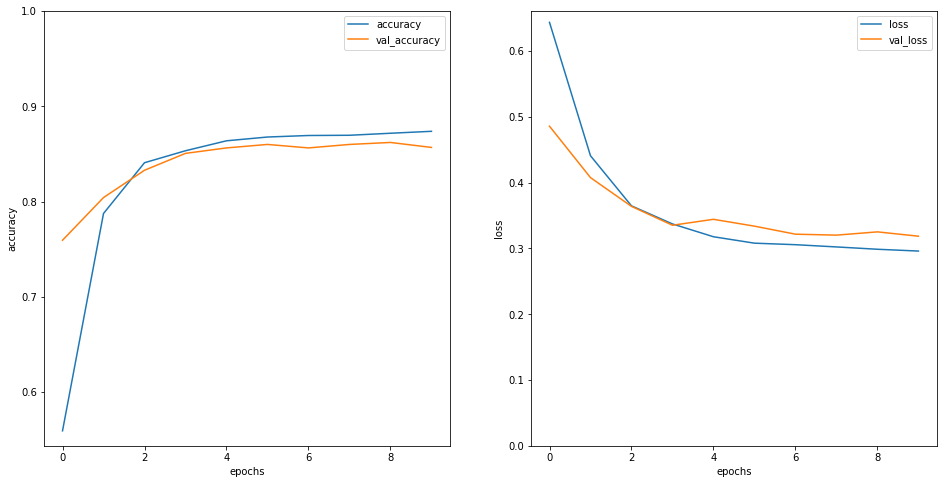

In [19]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [22]:
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')

predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 19ms/step
[0.6857532]


In [23]:
model = tf.keras.Sequential([
    encoder,

    tf.keras.layers.Embedding(
        len(encoder.get_vocabulary()),
        64,
        mask_zero=True
    ),

    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            64,
            return_sequences=True
        )
    ),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)

Epoch 1/10
391/391 [==============================] - 107s 241ms/step - loss: 0.6269 - accuracy: 0.5923 - val_loss: 0.4623 - val_accuracy: 0.7792
Epoch 2/10
391/391 [==============================] - 88s 224ms/step - loss: 0.3970 - accuracy: 0.8286 - val_loss: 0.3648 - val_accuracy: 0.8365
Epoch 3/10
391/391 [==============================] - 79s 202ms/step - loss: 0.3377 - accuracy: 0.8548 - val_loss: 0.3389 - val_accuracy: 0.8583
Epoch 4/10
391/391 [==============================] - 78s 200ms/step - loss: 0.3207 - accuracy: 0.8632 - val_loss: 0.3297 - val_accuracy: 0.8464
Epoch 5/10
391/391 [==============================] - 77s 198ms/step - loss: 0.3156 - accuracy: 0.8644 - val_loss: 0.3198 - val_accuracy: 0.8594
Epoch 6/10
391/391 [==============================] - 88s 226ms/step - loss: 0.3088 - accuracy: 0.8674 - val_loss: 0.3245 - val_accuracy: 0.8536
Epoch 7/10
391/391 [==============================] - 80s 204ms/step - loss: 0.3074 - accuracy: 0.8676 - val_loss: 0.3311 - val_a

In [26]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')

391/391 [==============================] - 39s 100ms/step - loss: 0.3327 - accuracy: 0.8618
Test loss: 0.33273690938949585
Test accuracy: 0.8617600202560425


In [27]:
# Predict on a sample text without padding
sample_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')

predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 4s 4s/step
[[-1.6289989]]


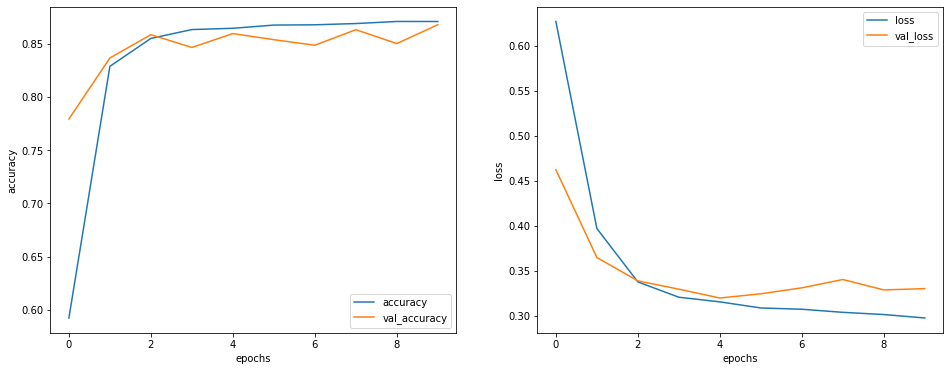

In [28]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')